In [1]:
import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output

import os
import json

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.loss = []
        self.val_loss_x = []
        self.val_loss_y = []
        self.fig = plt.figure()

    def on_batch_end(self, batch, logs):
        self.loss.append(logs["loss"])
            
    def on_epoch_end(self, epoch, logs):
        self.val_loss_x.append(len(self.loss))
        self.val_loss_y.append(logs["val_loss"])
        self.loss.append(logs["loss"])
        clear_output(wait=True)
        plt.plot(self.loss)
        plt.plot(self.val_loss_x, self.val_loss_y)
        plt.show()
        
    def save(self, output_path):
        directory = os.path.dirname(output_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        plt.figure()
        plt.plot(self.loss)
        plt.plot(self.val_loss_x, self.val_loss_y)
        plt.savefig(output_path)
        

In [2]:
from maya import standalone
standalone.initialize()

In [10]:
from fdda.common import forget_modules
forget_modules(["fdda"])

from fdda.model import SubsetModel

import json
import os

RECORDING_DIR = "D:\\M2\\DeepLearning\\Arm3\\recording_limits_1000"
MODEL_FILE = "Arm_model.json"

with open(os.path.join(RECORDING_DIR, MODEL_FILE), "r") as model_file:
    model_description = json.load(model_file)   


Forgetting module fdda.model
Forgetting module fdda.common
Forgetting module fdda


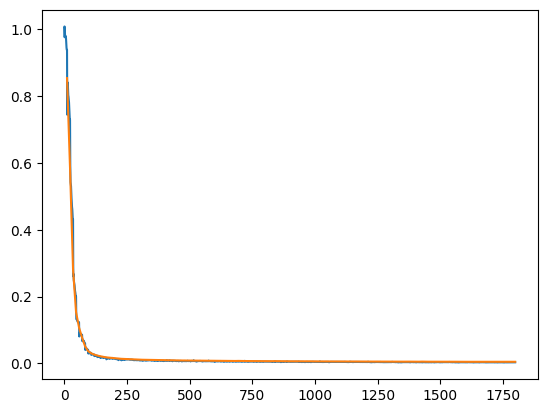

11/11 [==============================] - 0s 27ms/step - loss: 0.0032 - mae: 0.0376 - val_loss: 0.0048 - val_mae: 0.0448
Model: "FDDA_L_pinky_3_skn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_226 (Dense)           (None, 128)               1664      
                                                                 
 dense_227 (Dense)           (None, 128)               16512     
                                                                 
 dense_228 (Dense)           (None, 177)               22833     
                                                                 
Total params: 41,009
Trainable params: 41,009
Non-trainable params: 0
_________________________________________________________________


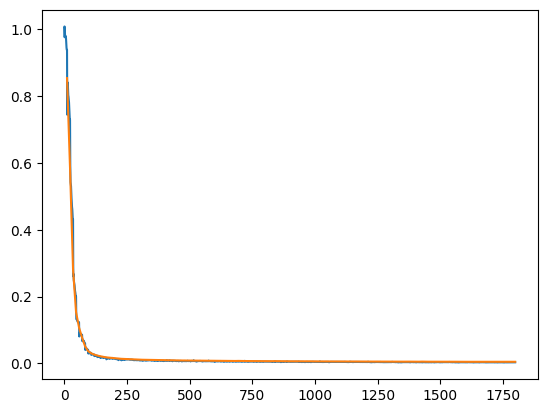

In [11]:
TRAINED_DIR = "D:\\M2\\DeepLearning\\Arm3\\trained_limits_128"

history_graph = LossHistory()
logs = {}
for subset_description in model_description["subsets"]:
    subset_model = SubsetModel.from_description(subset_description, model_description["name"])
    inputs, outputs = subset_model.read_associated_recording(RECORDING_DIR)
    # Get rid of the last row of the inputs (homogenous coordinates) which is always equal to [0, 0, 0, 1]
    inputs = inputs.reshape(inputs.shape[0], -1, 4, 4)[:, :, :3].reshape(inputs.shape[0], -1)
    
    history = subset_model.train(inputs, outputs, layer_size=128, activation="tanh", epochs=150, callbacks=[history_graph])
    subset_model.model.summary()
    history_graph.save(os.path.join(TRAINED_DIR, f"{model_description['name']}_{subset_model.subset.main_joint}.png"))
    subset_model.save(TRAINED_DIR)
        
with open(os.path.join(TRAINED_DIR, MODEL_FILE), "w") as model_file:
    json.dump(model_description, model_file, indent=4)
    